# **SENTIMENTAL ANALYSIS ON CORONA TWEETS**

The test dataset contains 3,798 entries and the training dataset has 41,157 entries, each with six columns:


*  UserName, ScreenName, Location,
*  TweetAt (the date of the tweet), OriginalTweet, and Sentiment.

Both datasets seem structured to analyze sentiments expressed in tweets related to a specific topic, likely providing insights into public opinion and reaction.

# **METHODOLOGY USED:**


*  Naives Bayes (Baseline Model) Method

*   LLM with LSTM layers (DistilBERT) Method
*   RNN architecture with LSTM layers Method




For building the deep learning model, the Hugging Face's Transformers library and TensorFlow were employed, while the Naive Bayes model was developed using scikit-learn. To facilitate faster training of the neural network, GPU acceleration was utilized, specifically using an A100 GPU on Google Colab.



# **SETTING UP ENVIRONMENT AND LIBRARIES**

In [ ]:
!pip install emoji
!pip install transformers==4.37.2
!pip install tensorflow==2.15.1

In [1]:
# General Purpose Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Progress Bar
from tqdm import tqdm

# Data Preprocessing
import re, string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Keras and TensorFlow for Deep Learning
import tensorflow as tf
from tensorflow import keras

# Transformers for NLP
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig

# Model Training Enhancements and Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging

# Configuration and Warnings
hf_logging.set_verbosity_error() # Hiding Huggingface Warnings
warnings.filterwarnings("ignore") # Suppressing Warnings

In [ ]:
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
plt.style.use('ggplot')

In [5]:
#set seed for reproducibility
seed=1234

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 640x480 with 0 Axes>

In [6]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# **LOAD DATA AND EDA**

In [72]:
tweets_train = pd.read_csv("Corona_train.csv", encoding='ISO-8859-1')
tweets_test = pd.read_csv("Corona_test.csv", encoding='ISO-8859-1')

In [8]:
tweets_train.info()
tweets_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+

In [9]:
tweets_train.drop_duplicates(subset='OriginalTweet',inplace=True)
tweets_test.drop_duplicates(subset='OriginalTweet',inplace=True)

In [10]:
tweets_train.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [11]:
tweets_test.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

the missign values are for only location which is not necessary our focus of attention so we are going to leave the data the same

In [73]:
tweets_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
tweets_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


# **VISUAL INSIGHT**

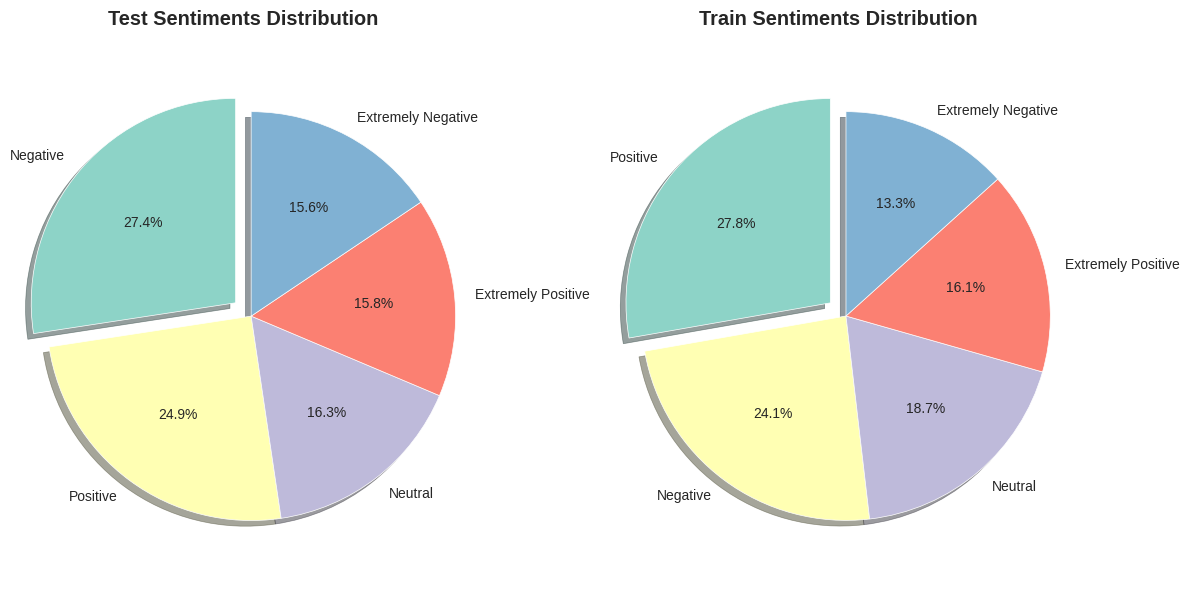

In [14]:
# Check the distribution of sentiments after encoding
sentiment_distribution_train = tweets_train['Sentiment'].value_counts()
sentiment_distribution_test = tweets_test['Sentiment'].value_counts()

explode = (0.1, 0, 0, 0, 0)  # Explode the 1st slice ('Positive')

# Pie chart
labels_test = sentiment_distribution_test.index
sizes_test = sentiment_distribution_test.values


labels_train = sentiment_distribution_train.index
sizes_train = sentiment_distribution_train.values

# Using a predefined palette: 'Set3' for example
color_palette_test = plt.get_cmap('Set3')(range(len(labels_test)))
color_palette_train = plt.get_cmap('Set3')(range(len(labels_train)))

# Create subplots: 1 row, 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for tweets_test
ax[0].pie(sizes_test, explode=explode, labels=labels_test, autopct='%1.1f%%', colors= color_palette_test , shadow=True, startangle=90)
ax[0].set_title('Test Sentiments Distribution')
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Pie chart for tweets_train
ax[1].pie(sizes_train, explode=explode, labels=labels_train, autopct='%1.1f%%', colors= color_palette_train , shadow=True, startangle=90)
ax[1].set_title('Train Sentiments Distribution')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.tight_layout()
plt.show()

In both datasets, 'Positive' and 'Negative' sentiments have the largest shares, with 'Extremely Positive' and 'Extremely Negative' sentiments being less common. 'Neutral' sentiments make up the smallest portion of the test dataset but a slightly larger portion of the training dataset.

In [15]:
#Converting date to ussable panda format
tweets_train['TweetAt'] = pd.to_datetime(tweets_train['TweetAt'])

In [16]:
tweets_per_day = tweets_train['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

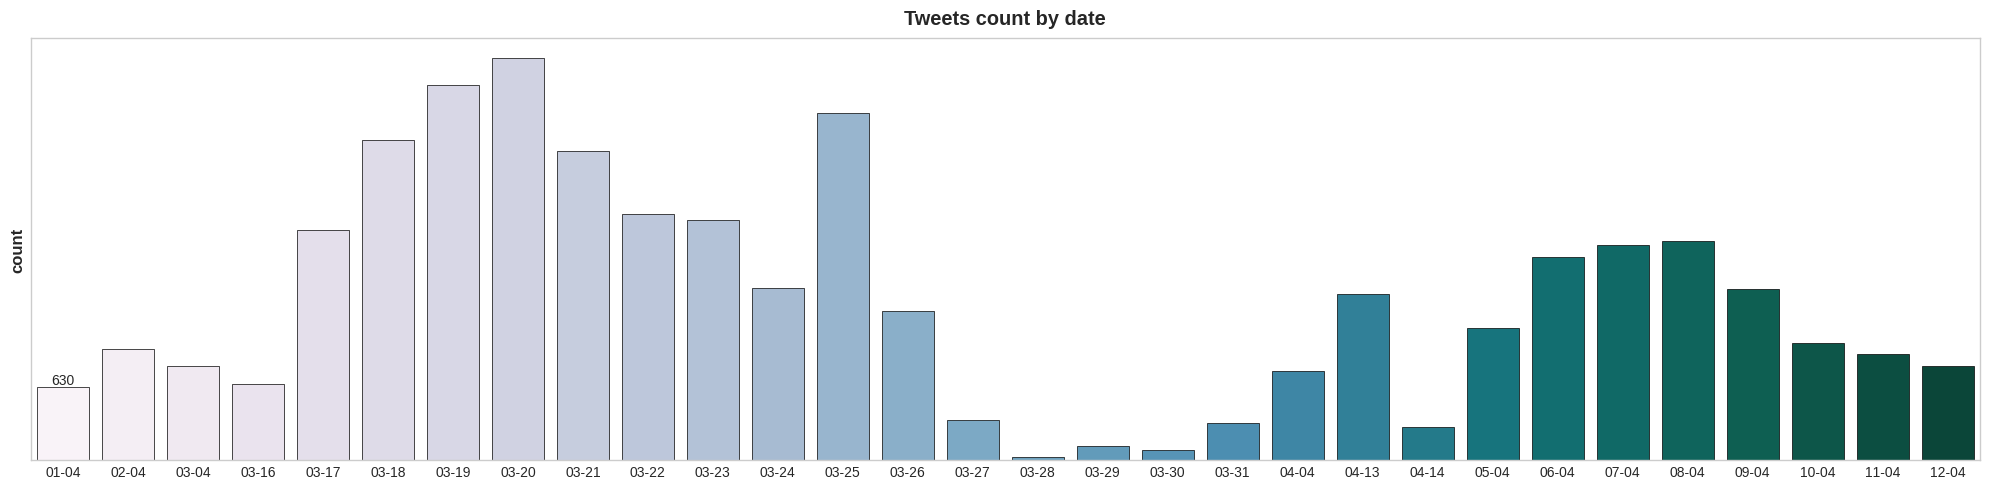

In [17]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='PuBuGn')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

The largest number of tweets, indicated by the tallest bar, occurred on March 20th, while other dates show varying lower counts. The chart suggests fluctuating volumes of tweets across the dates presented, with some peaks and troughs.

In [18]:
tweets_per_country = tweets_train['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

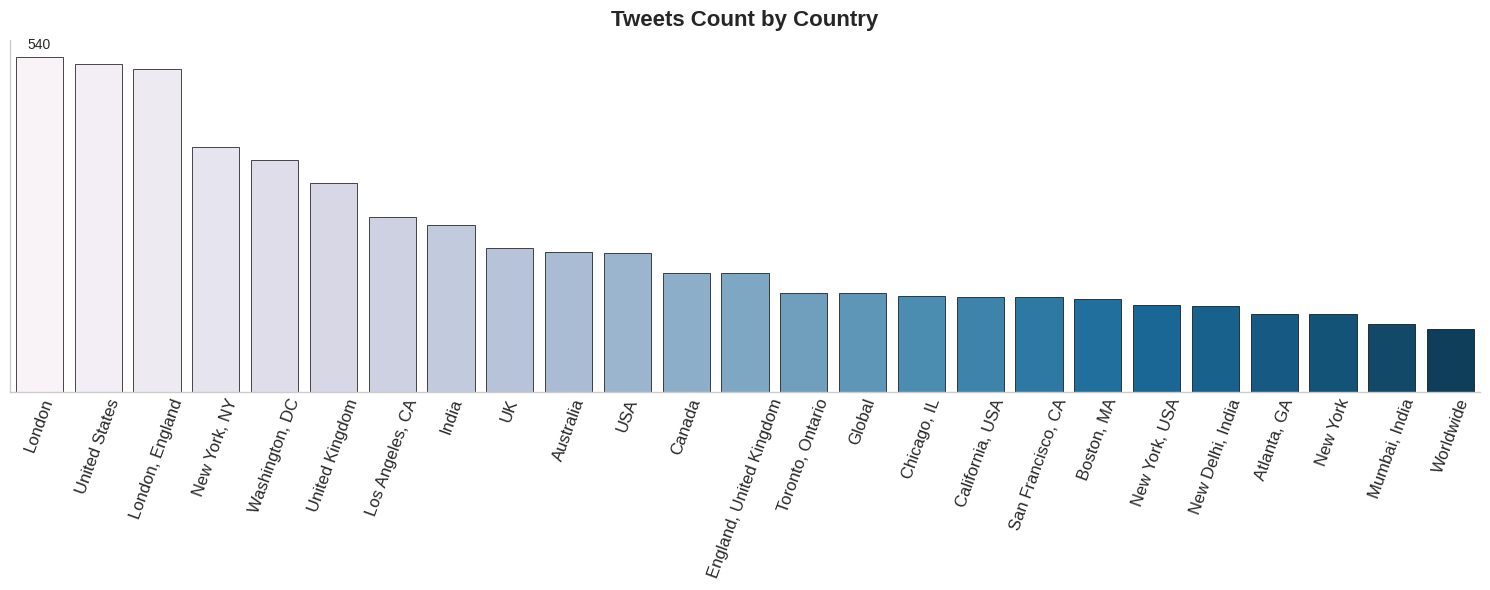

In [19]:
# a larger figure size to make the plot more readable
plt.figure(figsize=(15, 6))

# the bar plot
ax = sns.barplot(x='index', y='counts', data=tweets_per_country, edgecolor='black', ci=False, palette='PuBu')

# Customize the title and labels
plt.title('Tweets Count by Country', fontsize=16, fontweight='bold')
plt.xticks(rotation=70, fontsize=12)
plt.yticks([])  # Hides the y-tick labels

# Add bar labels for better readability
ax.bar_label(ax.containers[0], padding=3, fontsize=10)

# Remove the 'count' label on the y-axis as the y-ticks are hidden
plt.ylabel('')
plt.xlabel('')

# Remove the top and right spines for a cleaner look
sns.despine(top=True, right=True)

# Show the plot
plt.show()

The chart shows that London has the highest count, closely followed by the United States. Other significant contributions come from locations like New York, Washington, D.C., and Los Angeles. The chart also includes counts from other countries and cities such as India, the UK, Australia, and Canada, among others, with counts decreasing from left to right. The y-axis shows a numerical count (with the highest visible label being 540), suggesting the volume of tweets.

In [20]:
max_words = []
for row in tweets_train['OriginalTweet']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 64


# **DATA CLEANING AND LABELLING**

In [74]:
#Deleting the URL's in the tweets
train_str = tweets_train['OriginalTweet'][0]
print(train_str)

def remove_https(row):
    return re.sub(r'http\S+', '', row)

remove_https(train_str)

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8


'@MeNyrbie @Phil_Gahan @Chrisitv  and  and '

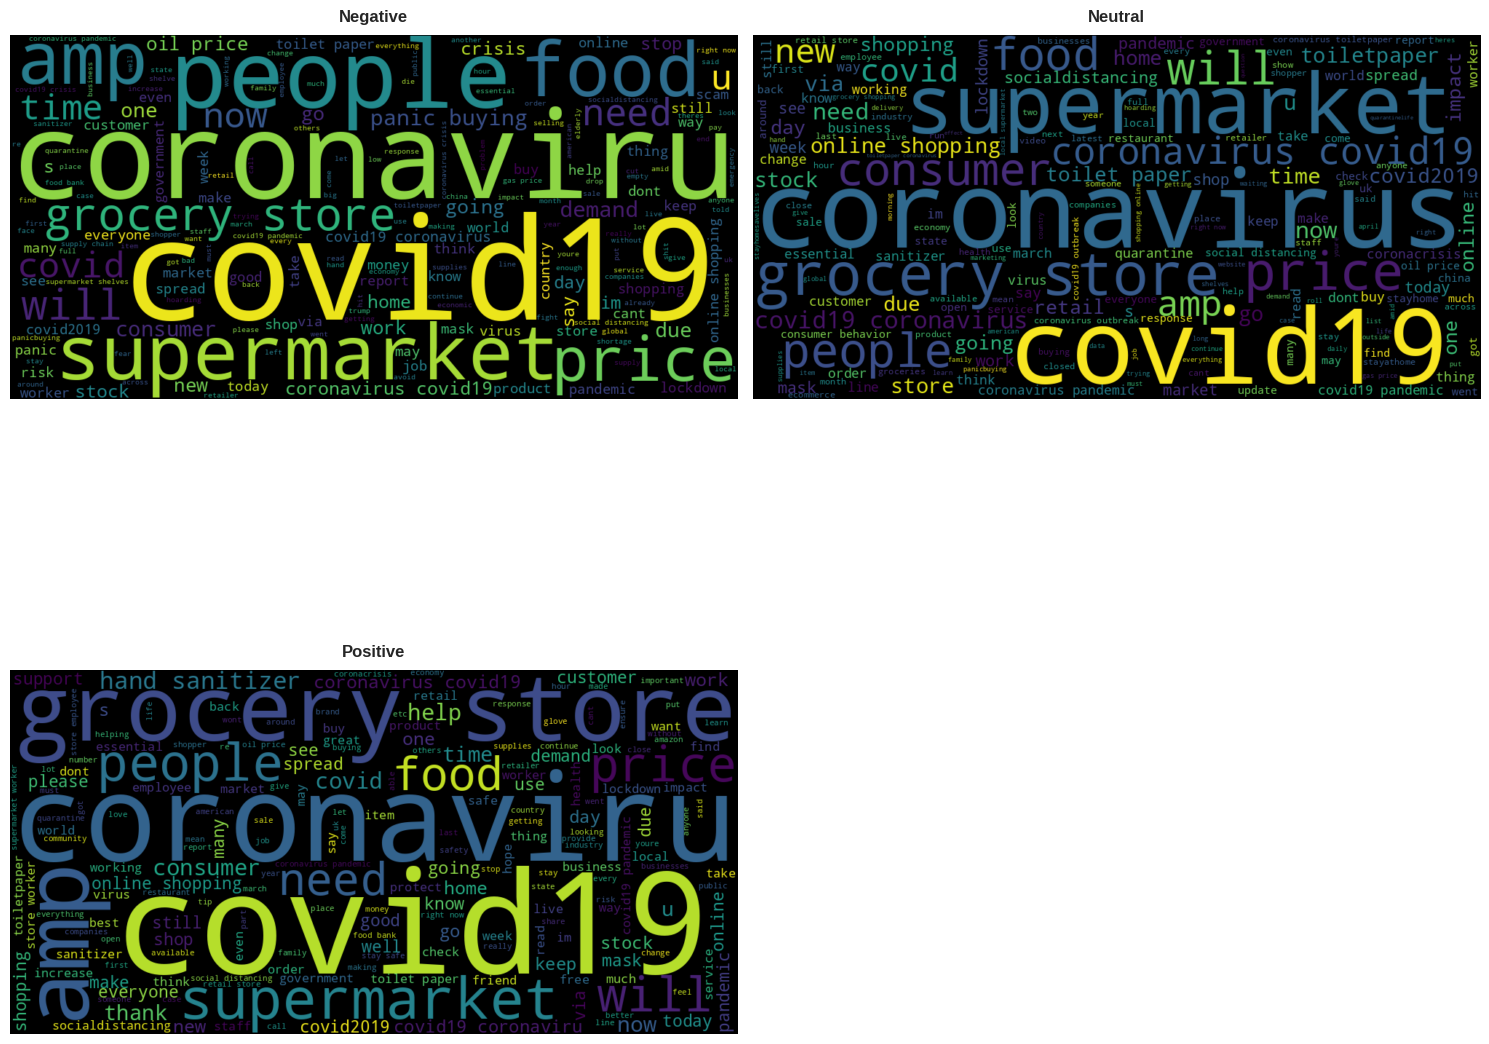

In [ ]:
# Combine Negative and Extremely Negative tweets for the negative category
negative_words = tweets_train[tweets_train['Sentiment'].isin(['Negative', 'Extremely Negative'])]['OriginalTweet'].tolist()

# Neutral remains unchanged
neutral_words = tweets_train[tweets_train['Sentiment'] == 'Neutral']['OriginalTweet'].tolist()

# Combine Positive and Extremely Positive tweets for the positive category
positive_words = tweets_train[tweets_train['Sentiment'].isin(['Positive', 'Extremely Positive'])]['OriginalTweet'].tolist()

# Convert all tweets in each category to strings
negative_words = [str(word) for word in negative_words]
neutral_words = [str(word) for word in neutral_words]
positive_words = [str(word) for word in positive_words]

# Generate word clouds for each sentiment category
negative_wordcloud = WordCloud(width=1000, height=500, background_color='black').generate(' '.join(negative_words))
neutral_wordcloud = WordCloud(width=1000, height=500, background_color='black').generate(' '.join(neutral_words))
positive_wordcloud = WordCloud(width=1000, height=500, background_color='black').generate(' '.join(positive_words))

# Display the word clouds
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative')

plt.subplot(2, 2, 2)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral')

plt.subplot(2, 2, 3)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive')

plt.tight_layout()
plt.show()



The image displays three word clouds, each representing different sentiment categories: Negative, Neutral, and Positive. The size of the words indicates their frequency or emphasis in the data from which the word clouds are generated:

**Negative Sentiment:** Prominent words include "coronavirus," "covid19," "supermarket," "grocery store," "food," "panic," "price," and "crisis," suggesting concerns about the pandemic's impact on grocery shopping and the economy.

**Neutral Sentiment:** Words like "covid19," "supermarket," "grocery store," "food," "people," and "consumer" are visible, indicating a more factual or descriptive tone in discussing the pandemic's effects on shopping habits and public spaces.

**Positive Sentiment:** Positive words such as "support," "help," "hand sanitizer," "thank," "safe," and "work" are evident, alongside "covid19" and "supermarket," implying a focus on supportive actions, gratitude, and safety measures related to grocery shopping during the pandemic.

In [75]:
tweets_train['OriginalTweet_no_URL'] = tweets_train['OriginalTweet'].apply(remove_https)
tweets_test['OriginalTweet_no_URL'] = tweets_test['OriginalTweet'].apply(remove_https)

In [23]:
#Label Encode the datasets
le = LabelEncoder()
tweets_train['Sentiment_label'] = le.fit_transform(tweets_train['Sentiment'])
tweets_test['Sentiment_label'] = le.transform(tweets_test['Sentiment'])

In [24]:
label_dict = (tweets_test[['Sentiment','Sentiment_label']].drop_duplicates()
              .sort_values(by='Sentiment_label')
              .reset_index(drop=True)['Sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Extremely Negative
1 Extremely Positive
2 Negative
3 Neutral
4 Positive


# **SPLITTING DATA**

In [25]:
# Get the number training samples
num_train_samples = int(tweets_train.shape[0] * 0.9)

x_train = tweets_train['OriginalTweet_no_URL'][:num_train_samples]
y_train = tweets_train['Sentiment_label'][:num_train_samples]
x_val = tweets_train['OriginalTweet_no_URL'][num_train_samples:]
y_val = tweets_train['Sentiment_label'][num_train_samples:]

### Sanity Check
assert(len(x_train) + len(x_val) == tweets_train.shape[0])

print(f"{len(x_train)} training examples\n{len(x_val)} validation examples")

37041 training examples
4116 validation examples


In [26]:
x_test = tweets_test['OriginalTweet_no_URL']
y_test = tweets_test['Sentiment_label']
print(f"{len(x_test)} testing examples")

3798 testing examples


In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **NAIVE BAYES (BASELINE MODEL) METHOD**

**Further pre-processing is required:**

Omit all punctuation marks except hashtags (#)

Convert all text to lowercase

Eliminate stopwords

Apply stemming to the words

**Retained the hashtag symbol as it is integral to the distinct nature of tweets**

In [28]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

# Remove all puncutation
def clean_responses(text):
    ### Remove all puncutation
    string.punctuation = string.punctuation.replace('#','')
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')

    ### Lowercase
    text = text.lower()

    ### Removing stop words
    filtered_words = []
    for word in text.split():
        if word not in stop_words:
            filtered_words.append(word)

    ### Stemming words
    stemmed = [porter.stem(word) for word in filtered_words]

    return ' '.join(stemmed)

In [29]:
X_train_NB = tweets_train['OriginalTweet_no_URL'].apply(clean_responses)
y_train_NB = tweets_train['Sentiment_label']
X_test_NB = tweets_test['OriginalTweet_no_URL'].apply(clean_responses)
y_test_NB = tweets_test['Sentiment_label']

In [30]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train_NB, y_train_NB)

### Make predictions
y_hat = model.predict(X_test_NB)

# **RESULTS**

Accuracy: 0.3441284886782517


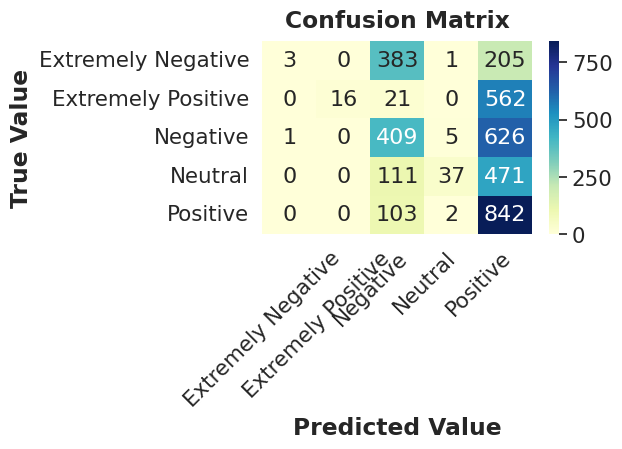

In [31]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_5 = ['Extremely Negative','Extremely Positive','Negative','Neutral','Positive']

def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="PuBuGn")
    sns.heatmap(pd.DataFrame(cm, index=labels_5,columns=[0,1,2,3,4]),
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2,3,4], labels_5, rotation=45)
    plt.ylabel("True Value")
    plt.show()

print_cf1(y_test_NB, y_hat)

Confusion matrix that provides detailed insight into the performance of a classification model across five sentiment classes: Extremely Negative, Extremely Positive, Negative, Neutral, and Positive. The confusion matrix compares the true labels with those predicted by the model.

**Extremely Negative:** 3 correctly predicted, 383 partially correct predicted as negaitve, but 205 were misclassified as Positive, and a few as Neutral.

**Extremely Positive:** 16 correctly predicted, 562 partially correct predicted as positive, some misclassified as Positive and Neutral, and 16 as Extremely Negative.

**Negative:** 409 correct predictions, but a notable number (626) were misclassified as Positive, with a few as Extremely Negative and Neutral.

**Neutral:** 37 correctly identified, with misclassifications primarily as Positive and and Negative.

**Positive:** 842 correct predictions, though quite a few (103) were misclassified as Negative, with a small number as Neutral.



In [32]:
print(classification_report(y_test_NB, y_hat, target_names=labels_5))

                    precision    recall  f1-score   support

Extremely Negative       0.75      0.01      0.01       592
Extremely Positive       1.00      0.03      0.05       599
          Negative       0.40      0.39      0.40      1041
           Neutral       0.82      0.06      0.11       619
          Positive       0.31      0.89      0.46       947

          accuracy                           0.34      3798
         macro avg       0.66      0.27      0.21      3798
      weighted avg       0.60      0.34      0.25      3798



**Extremely Negative:** Precision is high at 0.75, indicating that when it predicts this class, it is correct 75% of the time. However, recall is very low at 0.01, meaning it only correctly identifies 1% of all actual Extremely Negative cases. The F1-score, which balances precision and recall, is consequently low at 0.01, showing poor performance for this class.

**Extremely Positive:** Shows perfect precision (1.00), but like Extremely Negative, it has a very low recall of 0.03. The F1-score is 0.05, indicating the model is not effectively identifying this class.

**Negative:** Precision is 0.40 and recall is nearly the same at 0.39, resulting in a balanced F1-score of 0.40. This suggests moderate performance in identifying Negative sentiment.

**Neutral:** Has a high precision of 0.82, indicating strong reliability in the model's predictions for this class. However, recall is low at 0.06, and so the F1-score is 0.11, which shows the model rarely identifies Neutral cases correctly.

**Positive:** The precision is the lowest among all classes at 0.31, meaning it often incorrectly labels tweets as Positive. However, it has a high recall of 0.89, suggesting it identifies a large proportion of Positive cases. The F1-score is higher at 0.46 due to the high recall.

**Overall Accuracy:** The model correctly predicts the sentiment 34% of the time across all classes.

**Macro Avg:** On average, each class has a precision of 0.66, a recall of 0.27, and an F1-score of 0.21. This indicates a discrepancy between the classes, with some performing well and others poorly.

**Weighted Avg**: Taking class support into account, the weighted average precision is 0.60, and the F1-score is 0.25, factoring in the model's tendency to misclassify tweets as Positive.

# **LLM METHOD WITH LSTM (DistilBERT)**

In [33]:
MODEL_NAME = 'distilbert-base-cased'

In [34]:
# Loading the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [35]:
#Finding the max token sequence in the training set
max_val = 0
for sent in (x_train.tolist() + x_train.tolist() + x_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass

print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 232


In [36]:
MAX_LENGTH = 234

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH,
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=True,
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

The maximum sequence length for the input to the deep learning model will be configured to 234 tokens. This accounts for the longest token sequence identified, with an additional allowance for the special tokens [CLS] and [SEP] that are required for model processing.

In [37]:
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)
X_val = tokenize(x_val, tokenizer)

100%|██████████| 4116/4116 [00:02<00:00, 1507.10it/s]


In [38]:
# Entry insight
index_num = 0

print(tweets_train.loc[index_num]['Sentiment'], '\n')

print(x_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

Neutral 

@MeNyrbie @Phil_Gahan @Chrisitv  and  and  

ID's	Input Tokens
101	[CLS]
137	@
2508	Me
2249	##N
12577	##yr
9725	##bie
137	@
5676	Phil
168	_
144	G
14063	##ahan
137	@
2929	Chris
2875	##it
1964	##v
1105	and
1105	and
102	[SEP]


# **MODEL CREATION**

In [40]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(5, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 234)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 234)]                0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6519091   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 234, 768)   2          'masked_token[0][0]']        
                             , hidden_states=((None, 23                                           
                             4, 768),                                                         

This output describes the architecture of a deep learning model named "model", which is tailored for text processing with the following layers and configurations:

**Input Layers:** Two input layers, input_token and masked_token, each accepting an input shape of (None, 234), where None allows for a variable batch size and 234 is the sequence length of the input tokens.

**DistilBERT Layer:** Utilizes the TFDistilBertModel from Hugging Face's Transformers, designed to output the last hidden state of shape (None, 234, 768) among other hidden states and attentions across various layers. This layer has 65,190,912 parameters, making up the bulk of the model's complexity.

**Bidirectional Layer: **A bidirectional wrapper applied to an RNN, LSTM, or GRU, which outputs (None, 234, 256). It doubles the output dimension because it processes the sequence in both directions and has 918,528 parameters.

**Global Max Pooling 1D:** Reduces the output of the bidirectional layer to a 1D tensor by taking the maximum value over the time dimension, resulting in an output shape of (None, 256).

**Dense Layer:** A fully connected neural network layer with an output shape of (None, 64) and 16,448 parameters, it probably serves as a penultimate processing step before classification.

**Dropout Layer:** Applied to the dense layer with an unspecified dropout rate, this layer helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

**Output Dense Layer:** The final dense layer with an output shape of (None, 5), indicating that the model is classifying inputs into five categories. It has 325 parameters.

**Total Parameters:** The model has 66,126,213 parameters in total, of which 935,301 are trainable, and the rest are part of the pre-trained DistilBERT layer and are not trainable in this specific model configuration.

In [41]:
### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [42]:
#Callbacks
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [43]:
#Compile and train
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
2316/2316 [==============================] - 148s 59ms/step - loss: 1.2327 - accuracy: 0.4631 - val_loss: 1.0616 - val_accuracy: 0.5515 - lr: 0.0010
Epoch 2/10
2316/2316 [==============================] - 133s 57ms/step - loss: 1.0249 - accuracy: 0.5725 - val_loss: 0.9898 - val_accuracy: 0.5831 - lr: 0.0010
Epoch 3/10
2316/2316 [==============================] - 133s 57ms/step - loss: 0.9309 - accuracy: 0.6210 - val_loss: 0.9458 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 4/10
2316/2316 [==============================] - 133s 57ms/step - loss: 0.8588 - accuracy: 0.6525 - val_loss: 0.9213 - val_accuracy: 0.6324 - lr: 0.0010
Epoch 5/10
2316/2316 [==============================] - 133s 57ms/step - loss: 0.7969 - accuracy: 0.6790 - val_loss: 0.8822 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 6/10
2315/2316 [============================>.] - ETA: 0s - loss: 0.7361 - accuracy: 0.7058
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2316/2316 [==============

Lowest Validation Loss: epoch 5
Highest Validation Accuracy: epoch 8


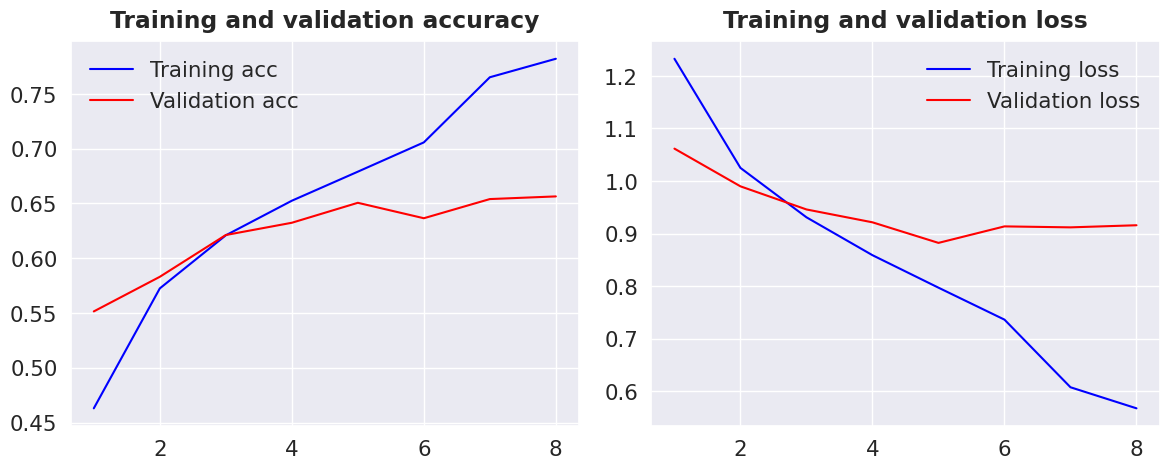

In [44]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

**Training and Validation Accuracy:** The blue line (training accuracy) increases steadily, indicating that the model is learning and improving its performance on the training data over epochs. The red line (validation accuracy) also increases but shows some fluctuations, suggesting the model's performance on unseen data is improving but not as consistently.

**Training and Validation Loss:** The blue line (training loss) shows a steady decline, which is expected as the model minimizes the error on the training data. The red line (validation loss) decreases initially but then shows an increase, indicating that the model may be starting to overfit to the training data and is losing generalization on the validation set.

The epochs on the x-axis range from 2 to 8, suggesting that these metrics are observed over six training epochs. The key point of interest is the divergence between training and validation lines, especially in the loss graph, where the model's performance on the validation set worsens after an initial improvement, a potential sign of overfitting.

In [45]:
def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [46]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

In [47]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

119/119 [==============================] - 10s 67ms/step


Accuracy: 0.6495523959978936


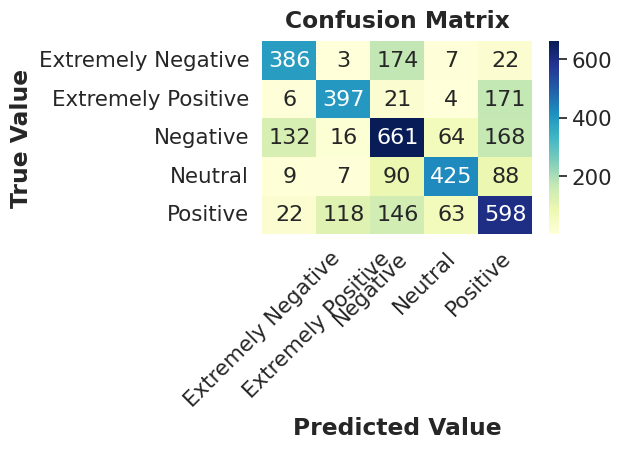

In [48]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

**Extremely Negative:** The model correctly predicted 386 cases, but it also partially misclassified 174 as Negative, among other errors.

**Extremely Positive:** 397 cases were correctly identified, with 171 misclassified as Positive.

**Negative:** The model correctly predicted 661 cases as Negative, with notable misclassifications including 132 as Extremely Negative and 168 as Positive.

**Neutral:** Correctly predicted 425 cases, but also misclassified 90 as Negative and 88 as Positive.

**Positive:** Correct predictions were 598, but it was often confused with Extremely Negative (22 cases) and Negative (146 cases).

The matrix suggests that the model is relatively good at identifying 'Positive' sentiments compared to other classes but shows some confusion between the 'Negative' categories and 'Positive' predictions.

In [49]:
print(classification_report(y_test, y_hat, target_names=labels_5))

                    precision    recall  f1-score   support

Extremely Negative       0.70      0.65      0.67       592
Extremely Positive       0.73      0.66      0.70       599
          Negative       0.61      0.63      0.62      1041
           Neutral       0.75      0.69      0.72       619
          Positive       0.57      0.63      0.60       947

          accuracy                           0.65      3798
         macro avg       0.67      0.65      0.66      3798
      weighted avg       0.66      0.65      0.65      3798



The report provides the precision, recall, and F1-score for a sentiment classification model across five classes, along with the overall accuracy:

**Extremely Negative:** The precision is 0.70, indicating that 70% of the predicted Extremely Negative sentiments are correct. The recall is slightly lower at 0.65, meaning the model correctly identifies 65% of all actual Extremely Negative instances. The F1-score, which is a harmonic mean of precision and recall, is 0.67.

**Extremely Positive:** This class has a precision of 0.73 and a recall of 0.66, leading to an F1-score of 0.70. This shows a fairly balanced performance in identifying Extremely Positive sentiments.

**Negative:** The precision here is 0.61 with a recall of 0.63, resulting in an F1-score of 0.62. This suggests a modest level of accuracy in classifying Negative sentiments.

**Neutral:** Shows a precision of 0.75 and a recall of 0.69, with an F1-score of 0.72. These are the highest scores among all classes, indicating that the model is quite reliable in predicting Neutral sentiments.

**Positive:** The model has a precision of 0.57 and a recall of 0.63, yielding an F1-score of 0.60. This indicates that while the model is reasonably good at identifying Positive cases, it also has a relatively higher rate of false positives compared to other classes.

**Overall Accuracy:** The model has an accuracy of 0.65, meaning it correctly predicts the sentiment 65% of the time.

**Macro Avg:** The average scores across all classes are 0.67 for precision, 0.65 for recall, and 0.66 for the F1-score, which suggests a generally consistent performance across different sentiment classes.

**Weighted Avg:** Considering the support (the number of true instances for each label), the weighted average precision is 0.66 and the weighted average F1-score is 0.65. This takes into account the imbalance in the number of instances across classes.

In summary, the model shows a relatively uniform performance across different sentiment classes with a tendency towards higher precision and F1-scores for Neutral sentiments and somewhat lower performance for the Positive class.

# **RNN METHOD (LSTM MODEL)**

For the purpose of this method, we focus only the training dataset which had 41157 observations.

In [76]:
# Cleaned and preprocessed the data

tweets = tweets_train['OriginalTweet'].values
labels = tweets_train['Sentiment'].values

In [77]:
# Encode the labels into integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

The data was further split with 80% for training and 20% for testing

In [78]:
# Split the data into training and testing sets after labelling
tweets_trained, tweets_test, labels_train, labels_test = train_test_split(
    tweets, encoded_labels, test_size=0.2, random_state=42
)

In [79]:
# TensorFlow data pipeline
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [80]:
# Define a function to encode the string labels to integer indices
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [81]:
# Create a dataset from the tweets and labels
train_dataset = tf.data.Dataset.from_tensor_slices((tweets_trained, labels_train))
test_dataset = tf.data.Dataset.from_tensor_slices((tweets_test, labels_test))

In [82]:
# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [85]:
# Let's assume 'cleaned_tweets' is a list of all tweets after preprocessing
cleaned_tweets = tweets_train['OriginalTweet'].tolist()
words = Counter()

for tweet in cleaned_tweets:
    words.update(tweet.split())

# Total number of unique words
total_unique_words = len(words)

# Determine the vocabulary size that covers 95% of word occurrences
accumulated_frequency = 0
total_occurrences = sum(words.values())
vocab_coverage = 0.95
vocab_size = 0

for word, freq in words.most_common():
    accumulated_frequency += freq
    vocab_size += 1
    if accumulated_frequency / total_occurrences >= vocab_coverage:
        break

print(f'Total number of unique words: {total_unique_words}')
print(f'Recommended VOCAB_SIZE that covers 95% of word occurrences: {vocab_size}')

Total number of unique words: 136386
Recommended VOCAB_SIZE that covers 95% of word occurrences: 73621


# **MODEL CREATION**

In [86]:
# Define  model
VOCAB_SIZE = 73621

# Assuming 'train_texts' is a list or a dataset of strings (the tweets)
train_texts = tweets_train['OriginalTweet'].values

# Define the TextVectorization layer
text_vectorization_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
#text_vectorization_layer.adapt(train_dataset.map(lambda text, label: text))

# Adapt the TextVectorization layer to the training texts
text_vectorization_layer.adapt(train_texts)

# Define the model
model = tf.keras.Sequential([
    text_vectorization_layer,
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE + 1, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Adjust the number of neurons in the last layer to the number of sentiment classes
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])

In [87]:
model.compile(
    # Use SparseCategoricalCrossentropy for multi-class classification
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    # Add 'accuracy' to the metrics
    metrics=['accuracy']
)

In [89]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

Epoch 1/10
515/515 [==============================] - 40s 77ms/step - loss: 1.5531 - accuracy: 0.2931 - val_loss: 1.3740 - val_accuracy: 0.4139
Epoch 2/10
515/515 [==============================] - 15s 30ms/step - loss: 1.1861 - accuracy: 0.5033 - val_loss: 1.0414 - val_accuracy: 0.5876
Epoch 3/10
515/515 [==============================] - 13s 26ms/step - loss: 0.8452 - accuracy: 0.6829 - val_loss: 0.9790 - val_accuracy: 0.6285
Epoch 4/10
515/515 [==============================] - 12s 24ms/step - loss: 0.6189 - accuracy: 0.7945 - val_loss: 0.9644 - val_accuracy: 0.6600
Epoch 5/10
515/515 [==============================] - 12s 24ms/step - loss: 0.4671 - accuracy: 0.8605 - val_loss: 1.0497 - val_accuracy: 0.6644
Epoch 6/10
515/515 [==============================] - 12s 23ms/step - loss: 0.3647 - accuracy: 0.8993 - val_loss: 1.1681 - val_accuracy: 0.6586
Epoch 7/10
515/515 [==============================] - 12s 23ms/step - loss: 0.2962 - accuracy: 0.9225 - val_loss: 1.1616 - val_accuracy:

# **EVALUTION AND RESULTS**

In [90]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

129/129 [==============================] - 1s 8ms/step - loss: 1.4502 - accuracy: 0.6627
Test Loss: 1.4501615762710571
Test Accuracy: 0.6626579165458679


Lowest Validation Loss: epoch 4
Highest Validation Accuracy: epoch 7


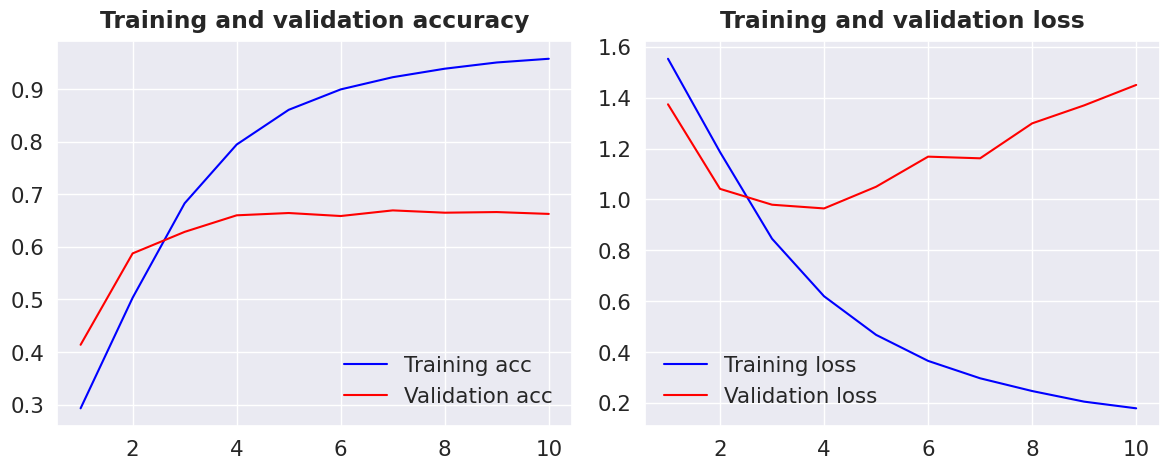

In [93]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

**Training and Validation Accuracy:** The blue line, representing training accuracy, shows a steady increase as the number of epochs progresses, indicating that the model is effectively learning from the training data. The red line, which represents validation accuracy, also increases but begins to plateau and slightly fluctuates as epochs increase, which may suggest the beginning of overfitting or that the model has reached its capability on the validation data.

**Training and Validation Loss:** The blue line, representing training loss, shows a significant decrease, which indicates that the model is getting better at predicting the training data over time. However, the red line, representing validation loss, decreases initially but then starts to increase after epoch 6, which is a strong indication of overfitting. The model is learning patterns specific to the training data that do not generalize well to unseen data.

The x-axis of both graphs denotes the epoch number, ranging from 2 to 10, while the y-axis denotes the accuracy and loss metrics respectively. It's important for the modeler to monitor these trends, as a divergence between training and validation metrics often warrants adjustments in model complexity, training duration, or techniques to mitigate overfitting such as dropout, regularization, or additional data.







In [94]:
# Generate predictions for the test data
predictions = model.predict(tweets_test)

# model outputs is one-hot encoded predictions, we need to convert these to class labels
predicted_labels = np.argmax(predictions, axis=1)


test_labels = labels_test  # Make sure this is an array of labels, not one-hot encoded if your predictions are not one-hot encoded

258/258 [==============================] - 6s 7ms/step


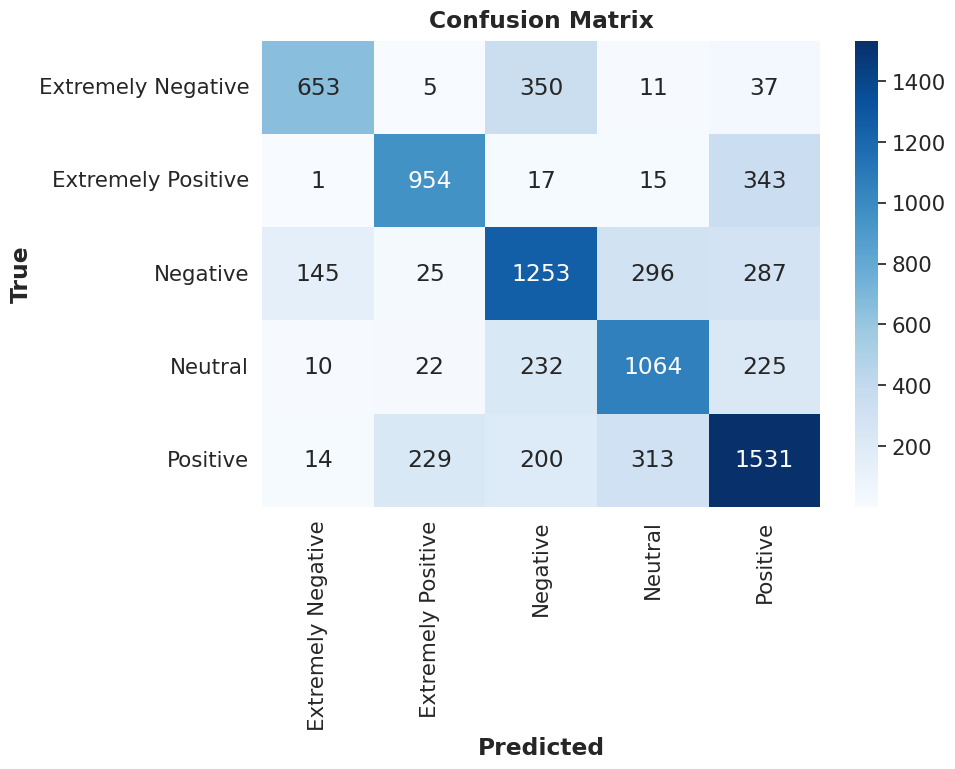

In [95]:
conf_matrix = confusion_matrix(test_labels, predictions.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Extremely Negative:** Most instances were correctly classified (653), with some confusion with the Negative class (350).

**Extremely Positive:** The majority were correctly predicted (954), with a smaller number confused with the Positive class (343).

**Negative:** The model correctly identified a significant number (1253) but also confused several instances with the Positive (287) and Extremely Negative (145) classes.

**Neutral:** The model achieved over a thousand correct predictions (1064) but had some confusion with the Positive class (225) and the Negative class (232).

**Positive:** This class had the highest number of correct predictions (1531) with some instances being misclassified as Extremely Positive (229) and Negative (200).

The matrix suggests that the model is quite proficient in distinguishing between the Positive class and the other sentiment classes, with a strong performance also in the Extremely Positive category. However, there is noticeable confusion between the Neutral, Negative, and Extremely Negative classes. The model seems to struggle to differentiate between these three, especially between Neutral and Negative. The shades of blue represent the number of instances, with darker shades indicating higher numbers. This visualization can help in further tuning the model to address these specific areas of confusion.